### Facial keypoints detection

#### Imports

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from keras.metrics import RootMeanSquaredError
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

import cv2

#### Constants

In [11]:
img_height, img_width = 96, 96

#### Dataset loading

The given dataset has already been separated to the train and the test part (2 .csv files zipped for the sake of good memory utilization). 
`train` and `test` archives contains .csv file with coordinates of each keypoint as well as the image.

In [12]:
train = pd.read_csv('./dataset/training.zip', compression='zip')
test = pd.read_csv('./dataset/test.zip', compression='zip')
IdLookupTable = pd.read_csv('./dataset/IdLookupTable.csv', header=0, sep=',', quotechar='"')

Each keypoint is specified by an (x, y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

*left_eye_center*, *right_eye_center*, *left_eye_inner_corner*, *left_eye_outer_corner*, *right_eye_inner_corner*, *right_eye_outer_corner*, *left_eyebrow_inner_end*, *left_eyebrow_outer_end*, *right_eyebrow_inner_end*, *right_eyebrow_outer_end*, *nose_tip*, *mouth_left_corner*, *mouth_right_corner*, *mouth_center_top_lip*, *mouth_center_bottom_lip*

Left and right here refers to the point of view of the subject.

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

##### Train dataset preview
Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.

In [13]:
print('The number of samples into the train data is {}.'.format(train.shape[0]))

train.head().T

The number of samples into the train data is 7049.


,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


##### Test dataset preview
Each row contains ImageId and image data as row-ordered list of pixels

In [14]:
print('The number of samples into the test data is {}.'.format(test.shape[0]))

test.head()

The number of samples into the test data is 1783.


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


#### Data preprocessing - missing values

In [15]:
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [16]:
print('Maximal number of missing columns is %d, which is %.2f%%' %(max(train.isnull().sum()), 100. * max(train.isnull().sum()) / train.shape[0]))

Maximal number of missing columns is 4824, which is 68.44%


##### Dropping missing values
First technique can be to drop all missing values. This will drop almost ~70% of the training dataset so it wont be used.

In [22]:
def drop_missing_values():  
    train_dropped_missing_values = train.dropna()
    return train_dropped_missing_values

##### Fill missing values
The forward fill method (ffill) fills in missing values with the previous value in the column. It "propagates" the previous value forward. Common choices for filling in the missing values, such as mean or median, do not apply well here, because the mean of every key point will not represent anything. On the other hand, images from the dataset are quite similar to each others, so filling in some key points to be positioned as same as the previous similar key point will not make a colossal mistake. 

In [25]:
def fill_missing_values():  
    train_filled_values = train.fillna(method = 'ffill', inplace=False)
    return train_filled_values

In [26]:
def solve_missing_values(method: str):
    if method == 'drop':
        return drop_missing_values()
    elif method == 'ffill':
        return fill_missing_values()

##### Solve missing values

In [27]:
train_no_missing_values = solve_missing_values('ffill')

In [28]:
number_of_rows_train, number_of_columns_train = train_no_missing_values.shape
print('Shape of train data without any missing values are ({}, {}).'.format(number_of_rows_train , number_of_columns_train))
train_no_missing_values.isnull().sum().any()

Shape of train data without any missing values are (7049, 31).


False

There is no missing values any more!

#### Images and keypoints preview

The last column (accessed using the name `Image`) of the train dataset represents an image. If there are any blank spaces, represents by null values, in the pixels they will be replaced with 0. The pixel values will be normalized in the range [0, 1].

In [29]:
images = []
labels = []

for index, sample in train_no_missing_values.iterrows():

    face_pixel = np.array(sample['Image'].split(' '), dtype='float')
    face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
    images.append(face_pixel)

    labels.append(sample[0:30])

images = np.array(images)
labels = np.array(labels, dtype = 'float')

images.shape, labels.shape

((7049, 96, 96, 1), (7049, 30))

(96, 96)


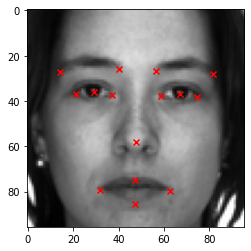

In [30]:
sample_image_number = 1235
img_for_show = np.squeeze(images[sample_image_number])
print(img_for_show.shape)
plt.imshow(img_for_show, cmap='gray')
plt.scatter(labels[sample_image_number][0:30:2], labels[sample_image_number][1:30:2], marker='x', c = 'red')
plt.show()

#### Model

Testset will be splitted into 3 groups: train, validate, test. The relative size of each group will be the following (train, validate, test) = (90%, 5%, 5%)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print('Shape of train dataset is ({}, {}).'.format(X_train.shape, y_train.shape))
print('Shape of validation dataset is ({}, {}).'.format(X_val.shape, y_val.shape))
print('Shape of test dataset is ({}, {}).'.format(X_test.shape, y_test.shape))


Shape of train dataset is ((6344, 96, 96, 1), (6344, 30)).
Shape of validation dataset is ((352, 96, 96, 1), (352, 30)).
Shape of test dataset is ((353, 96, 96, 1), (353, 30)).


Hence this dataset is small (~10<sup>4</sup> inputs) this division will work fine.

In [32]:
def plot_loss(history, model_name, plt):
    loss = history['loss']
    val_loss = history['val_loss']
    plt.plot(loss, "--", linewidth=3, label="train [" + model_name + "]")
    plt.plot(val_loss, linewidth=3, label="val [" + model_name + "]")
    plt.legend()
    plt.grid()
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("log loss")
    plt.title("Loss graphic for " + model_name + " model")
    plt.savefig(model_name + "_loss.png", dpi=90)
    plt.show()

##### Neural Netowrk

In [49]:
model_nn = Sequential(name="DeepNN")

model_nn.add(Flatten(input_shape=(96, 96, 1)))

model_nn.add(Dense(1024, activation='relu'))

model_nn.add(Dense(512, activation='relu'))

model_nn.add(Dense(256, activation='relu'))

model_nn.add(Dense(128, activation='relu'))

model_nn.add(Dense(64, activation='relu'))

model_nn.add(Dense(64, activation='relu'))

model_nn.add(Dense(30))

plot_model(model_nn, to_file='DeepNN.png', show_shapes=True)

model_nn.summary()

Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_21 (Dense)            (None, 1024)              9438208   
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 64)                4160 

In [50]:
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [51]:
history_nn = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                            epochs=100, 
                            batch_size=32, 
                            shuffle=True)

Epoch 1/100
199/199 [==============================] - 3s 8ms/step - loss: 2073.2849 - root_mean_squared_error: 45.5333 - accuracy: 0.1969 - mae: 20.3254 - val_loss: 332.4541 - val_root_mean_squared_error: 18.2333 - val_accuracy: 0.2188 - val_mae: 14.2359
Epoch 2/100
199/199 [==============================] - 1s 6ms/step - loss: 195.6167 - root_mean_squared_error: 13.9863 - accuracy: 0.3025 - mae: 10.7511 - val_loss: 212.2006 - val_root_mean_squared_error: 14.5671 - val_accuracy: 0.0312 - val_mae: 11.6295
Epoch 3/100
199/199 [==============================] - 1s 6ms/step - loss: 155.5940 - root_mean_squared_error: 12.4737 - accuracy: 0.3640 - mae: 9.5979 - val_loss: 159.4076 - val_root_mean_squared_error: 12.6257 - val_accuracy: 0.2983 - val_mae: 9.7335
Epoch 4/100
199/199 [==============================] - 1s 5ms/step - loss: 139.4007 - root_mean_squared_error: 11.8068 - accuracy: 0.3681 - mae: 9.0713 - val_loss: 141.9260 - val_root_mean_squared_error: 11.9133 - val_accuracy: 0.2330 -

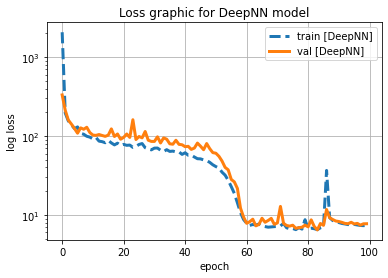

In [52]:
plot_loss(history_nn.history, model_nn.name, plt)

In [53]:
print("All metrics: {}.".format(model_nn.metrics_names))
evaluations_nn = model_nn.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model_nn.name, evaluations_nn[model_nn.metrics_names.index('accuracy')]))


All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
12/12 [==============================] - 0s 3ms/step - loss: 5.9020 - root_mean_squared_error: 2.4294 - accuracy: 0.7280 - mae: 1.4228
Accuracy of DeepNN model is: 0.7280%


#### Convolution Neural Network

In [ ]:
model_cnn = Sequential(name="CNN")

model_cnn.add(Conv2D(128, kernel_size=(3, 3), 
                      input_shape=(img_height, img_width, 1), 
                      activation='relu', 
                      padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(128, kernel_size=(3, 3),activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2)))

model_cnn.add(Flatten())

model_cnn.add(Dense(256,activation='relu'))
model_cnn.add(Dropout(0.1))

model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.1))

model_cnn.add(Dense(30))

plot_model(model_cnn, to_file='CNN.png', show_shapes=True)

model_cnn.summary()

In [ ]:
model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [ ]:
history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
177/177 [==============================] - 16s 41ms/step - loss: 169.9207 - root_mean_squared_error: 13.0354 - accuracy: 0.3212 - mae: 8.2701 - val_loss: 77.0718 - val_root_mean_squared_error: 8.7791 - val_accuracy: 0.6652 - val_mae: 7.0106
Epoch 2/100
177/177 [==============================] - 6s 36ms/step - loss: 39.8899 - root_mean_squared_error: 6.3158 - accuracy: 0.3942 - mae: 4.8707 - val_loss: 128.6036 - val_root_mean_squared_error: 11.3404 - val_accuracy: 0.7021 - val_mae: 10.1922
Epoch 3/100
177/177 [==============================] - 6s 36ms/step - loss: 31.4425 - root_mean_squared_error: 5.6074 - accuracy: 0.4504 - mae: 4.2862 - val_loss: 52.5073 - val_root_mean_squared_error: 7.2462 - val_accuracy: 0.6851 - val_mae: 6.1064
Epoch 4/100
177/177 [==============================] - 6s 36ms/step - loss: 28.5095 - root_mean_squared_error: 5.3394 - accuracy: 0.4799 - mae: 4.0555 - val_loss: 31.1515 - val_root_mean_squared_error: 5.5813 - val_accuracy: 0.7035 - val_mae: 4

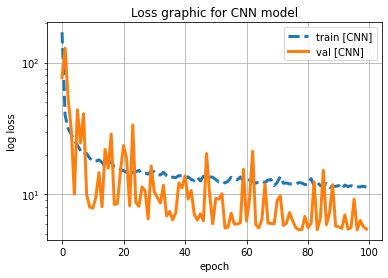

In [ ]:
plot_loss(history_cnn.history, model_cnn.name, plt)

In [60]:
# Define the model
model_lenet = Sequential(name="LeNet-5")

# Add the convolutional layers
model_lenet.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(96, 96, 1)))
model_lenet.add(MaxPool2D(pool_size=(2, 2)))
model_lenet.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the feature maps
model_lenet.add(Flatten())

# Add the dense layers
model_lenet.add(Dense(120, activation='relu'))
model_lenet.add(Dense(84, activation='relu'))

# Output layer with 30 output parameters (x, y) float64 numbers
model_lenet.add(Dense(30))

plot_model(model_lenet, to_file='LeNet-5.png', show_shapes=True)

model_lenet.summary()


Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 92, 92, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 46, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 7056)              0         
                                                                 
 dense_31 (Dense)            (None, 120)               8468

In [61]:
model_lenet.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [62]:
history_lenet = model_lenet.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
199/199 [==============================] - 2s 7ms/step - loss: 225.1021 - root_mean_squared_error: 15.0034 - accuracy: 0.4174 - mae: 9.9877 - val_loss: 100.9671 - val_root_mean_squared_error: 10.0482 - val_accuracy: 0.3665 - val_mae: 7.5396
Epoch 2/100
199/199 [==============================] - 1s 5ms/step - loss: 90.3509 - root_mean_squared_error: 9.5053 - accuracy: 0.5787 - mae: 7.1152 - val_loss: 83.8681 - val_root_mean_squared_error: 9.1580 - val_accuracy: 0.5881 - val_mae: 6.8309
Epoch 3/100
199/199 [==============================] - 1s 6ms/step - loss: 74.1741 - root_mean_squared_error: 8.6124 - accuracy: 0.6100 - mae: 6.4075 - val_loss: 91.7495 - val_root_mean_squared_error: 9.5786 - val_accuracy: 0.6165 - val_mae: 7.2646
Epoch 4/100
199/199 [==============================] - 1s 6ms/step - loss: 63.1549 - root_mean_squared_error: 7.9470 - accuracy: 0.6488 - mae: 5.8744 - val_loss: 72.1839 - val_root_mean_squared_error: 8.4961 - val_accuracy: 0.6392 - val_mae: 6.2821


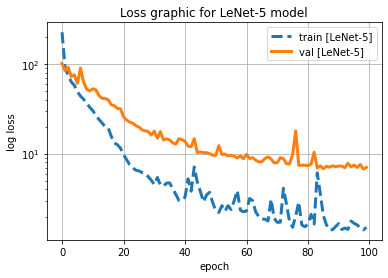

In [63]:
plot_loss(history_lenet.history, model_lenet.name, plt)

In [64]:
print("All metrics: {}.".format(model_lenet.metrics_names))
evaluations_lenet = model_lenet.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model_lenet.name, evaluations_lenet[model_lenet.metrics_names.index('accuracy')]))


All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
12/12 [==============================] - 0s 4ms/step - loss: 5.6714 - root_mean_squared_error: 2.3815 - accuracy: 0.7847 - mae: 1.5491
Accuracy of LeNet-5 model is: 0.7847%


In [ ]:
# Define the model
model_complex_lenet = Sequential()

# Add the convolutional layers
model_complex_lenet.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(96, 96, 1)))
model_complex_lenet.add(MaxPool2D(pool_size=(2, 2)))
model_complex_lenet.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_complex_lenet.add(MaxPool2D(pool_size=(2, 2)))


model_complex_lenet.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1)))
model_complex_lenet.add(BatchNormalization())
model_complex_lenet.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_complex_lenet.add(BatchNormalization())
model_complex_lenet.add(MaxPool2D(pool_size=(2, 2)))
model_complex_lenet.add(Dropout(0.25))

model_complex_lenet.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_complex_lenet.add(BatchNormalization())
model_complex_lenet.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_complex_lenet.add(BatchNormalization())
model_complex_lenet.add(MaxPool2D(pool_size=(2, 2)))
model_complex_lenet.add(Dropout(0.25))

# Flatten the feature maps
model_complex_lenet.add(Flatten())

# Add the dense layers
model_complex_lenet.add(Dense(512, activation='relu'))
model_complex_lenet.add(BatchNormalization())
model_complex_lenet.add(Dropout(0.5))
model_complex_lenet.add(Dense(256, activation='relu'))
model_complex_lenet.add(BatchNormalization())
model_complex_lenet.add(Dropout(0.5))

# Output layer with 30 output parameters (x, y) float64 numbers
model_complex_lenet.add(Dense(30))

plot_model(model_complex_lenet, to_file='Complex-LeNet-5.png', show_shapes=True)

model_complex_lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 92, 92, 6)         156       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 19, 19, 32)        4640      
                                                                 
 batch_normalization_4 (Batc  (None, 19, 19, 32)       1

In [ ]:
model_complex_lenet.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [ ]:
history_complex_lenet = model_complex_lenet.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
177/177 [==============================] - 4s 12ms/step - loss: 2542.6958 - root_mean_squared_error: 50.4252 - accuracy: 0.0424 - mae: 46.7722 - val_loss: 2009.4039 - val_root_mean_squared_error: 44.8264 - val_accuracy: 0.0057 - val_mae: 40.5066
Epoch 2/100
177/177 [==============================] - 2s 9ms/step - loss: 1286.1310 - root_mean_squared_error: 35.8627 - accuracy: 0.0771 - mae: 30.3334 - val_loss: 463.5764 - val_root_mean_squared_error: 21.5308 - val_accuracy: 0.0766 - val_mae: 16.0756
Epoch 3/100
177/177 [==============================] - 2s 9ms/step - loss: 203.8828 - root_mean_squared_error: 14.2788 - accuracy: 0.2378 - mae: 9.9536 - val_loss: 47.1161 - val_root_mean_squared_error: 6.8641 - val_accuracy: 0.5248 - val_mae: 4.6922
Epoch 4/100
177/177 [==============================] - 2s 9ms/step - loss: 52.1430 - root_mean_squared_error: 7.2210 - accuracy: 0.4556 - mae: 5.2628 - val_loss: 13.8620 - val_root_mean_squared_error: 3.7232 - val_accuracy: 0.5617 - va

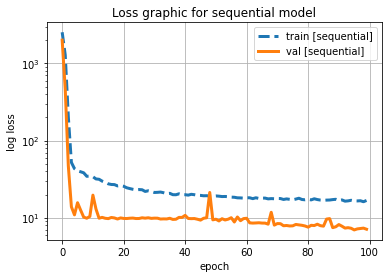

In [ ]:
plot_loss(history_complex_lenet.history, model_complex_lenet.name, plt)

In [ ]:
print("All metrics: {}.".format(model_complex_lenet.metrics_names))
evaluations_complex_lenet = model_complex_lenet.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model_complex_lenet.name, evaluations_complex_lenet[model_complex_lenet.metrics_names.index('accuracy')]))


All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
23/23 [==============================] - 0s 5ms/step - loss: 6.0732 - root_mean_squared_error: 2.4644 - accuracy: 0.7418 - mae: 1.5082
Accuracy of sequential model is: 0.7418%


In [ ]:
# Define the model
model_alexnet = Sequential()

# Add the convolutional layers
model_alexnet.add(Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(96, 96, 1), padding='same'))
model_alexnet.add(MaxPool2D(pool_size=(3, 3), strides=2))

model_alexnet.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
model_alexnet.add(MaxPool2D(pool_size=(3, 3), strides=2))

model_alexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(MaxPool2D(pool_size=(3, 3), strides=2))

# Flatten the feature maps
model_alexnet.add(Flatten())

# Add the dense layers
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))

# Output layer with 30 output parameters (x, y) float64 numbers
model_alexnet.add(Dense(30))

plot_model(model_alexnet, to_file='AlexNet.png', show_shapes=True)

model_alexnet.summary()

In [ ]:
model_alexnet.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [ ]:
history_alexnet = model_alexnet.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
177/177 [==============================] - 5s 21ms/step - loss: 1870.9342 - root_mean_squared_error: 43.2543 - accuracy: 0.2836 - mae: 18.6228 - val_loss: 106.2130 - val_root_mean_squared_error: 10.3060 - val_accuracy: 0.6284 - val_mae: 7.8674
Epoch 2/100
177/177 [==============================] - 3s 18ms/step - loss: 114.8289 - root_mean_squared_error: 10.7158 - accuracy: 0.4295 - mae: 8.1162 - val_loss: 61.1194 - val_root_mean_squared_error: 7.8179 - val_accuracy: 0.6284 - val_mae: 5.7347
Epoch 3/100
177/177 [==============================] - 3s 18ms/step - loss: 60.9700 - root_mean_squared_error: 7.8083 - accuracy: 0.4861 - mae: 5.8063 - val_loss: 17.2668 - val_root_mean_squared_error: 4.1553 - val_accuracy: 0.6284 - val_mae: 3.1632
Epoch 4/100
177/177 [==============================] - 3s 18ms/step - loss: 32.1899 - root_mean_squared_error: 5.6736 - accuracy: 0.5214 - mae: 4.2357 - val_loss: 11.1030 - val_root_mean_squared_error: 3.3321 - val_accuracy: 0.6284 - val_mae:

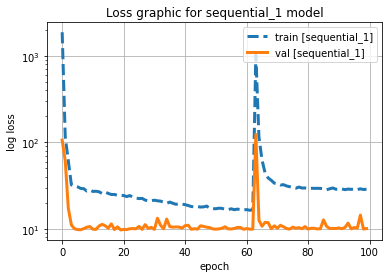

In [ ]:
plot_loss(history_alexnet.history, model_alexnet.name, plt)

In [ ]:
print("All metrics: {}.".format(model_alexnet.metrics_names))
evaluations_alexnet = model_alexnet.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model_alexnet.name, evaluations_alexnet[model_alexnet.metrics_names.index('accuracy')]))


All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
23/23 [==============================] - 0s 12ms/step - loss: 8.9970 - root_mean_squared_error: 2.9995 - accuracy: 0.6312 - mae: 1.8750
Accuracy of sequential_1 model is: 0.6312%


In [ ]:
# Define the model
model = Sequential()

# Add the convolutional layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1), padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add the dense layers
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 30 output parameters (x, y) float64 numbers
model.add(Dense(30))

plot_model(model, to_file='VGG-16.png', show_shapes=True)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 conv2d_18 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
177/177 [==============================] - 23s 110ms/step - loss: 30765.3184 - root_mean_squared_error: 175.4004 - accuracy: 0.2632 - mae: 32.5782 - val_loss: 56.9641 - val_root_mean_squared_error: 7.5475 - val_accuracy: 0.6284 - val_mae: 5.6692
Epoch 2/100
177/177 [==============================] - 19s 109ms/step - loss: 55.6061 - root_mean_squared_error: 7.4569 - accuracy: 0.4425 - mae: 5.6384 - val_loss: 10.1272 - val_root_mean_squared_error: 3.1823 - val_accuracy: 0.6284 - val_mae: 1.9419
Epoch 3/100
177/177 [==============================] - 19s 107ms/step - loss: 42.4352 - root_mean_squared_error: 6.5142 - accuracy: 0.4987 - mae: 4.9118 - val_loss: 10.1158 - val_root_mean_squared_error: 3.1805 - val_accuracy: 0.6284 - val_mae: 1.9848
Epoch 4/100
177/177 [==============================] - 18s 103ms/step - loss: 39.8794 - root_mean_squared_error: 6.3150 - accuracy: 0.5067 - mae: 4.7473 - val_loss: 16.9077 - val_root_mean_squared_error: 4.1119 - val_accuracy: 0.6284 - va

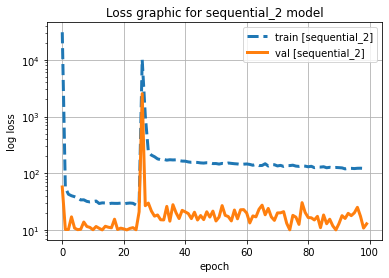

In [ ]:
plot_loss(history.history, model.name, plt)

In [ ]:
print("All metrics: {}.".format(model.metrics_names))
evaluations = model.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model.name, evaluations[model.metrics_names.index('accuracy')]))


All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
23/23 [==============================] - 1s 34ms/step - loss: 11.7558 - root_mean_squared_error: 3.4287 - accuracy: 0.6312 - mae: 2.5142
Accuracy of sequential_2 model is: 0.6312%


#### Visually evaluate the model

The DeepNN model gives ~72% while the LeNet-5 gives the ~78% accuracy. Both models will be visually evaluated on 20 images from unlabeled dataset.


DeepNN

In [71]:
def visually_evaluate_model(model_for_submission):
    images_for_submission = []

    for index, sample in test.iterrows():

        face_pixel = np.array(sample['Image'].split(' '), dtype='float')
        face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
        images_for_submission.append(face_pixel)

    images_for_submission = np.array(images_for_submission)

    print('Shape of dataset for visually testing {}.'.format(images_for_submission.shape))

    predictions = model_for_submission.predict(images_for_submission)

    fig = plt.figure(figsize=(20,16))
    for i in range(20):
        image = images_for_submission[i].reshape(96,96)
        axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        axis.imshow(image, cmap='gray')
        axis.scatter(predictions[i][0::2], predictions[i][1::2], marker='x', c = 'red')
    plt.show()

Shape of dataset for visually testing (1783, 96, 96, 1).
56/56 [==============================] - 0s 2ms/step


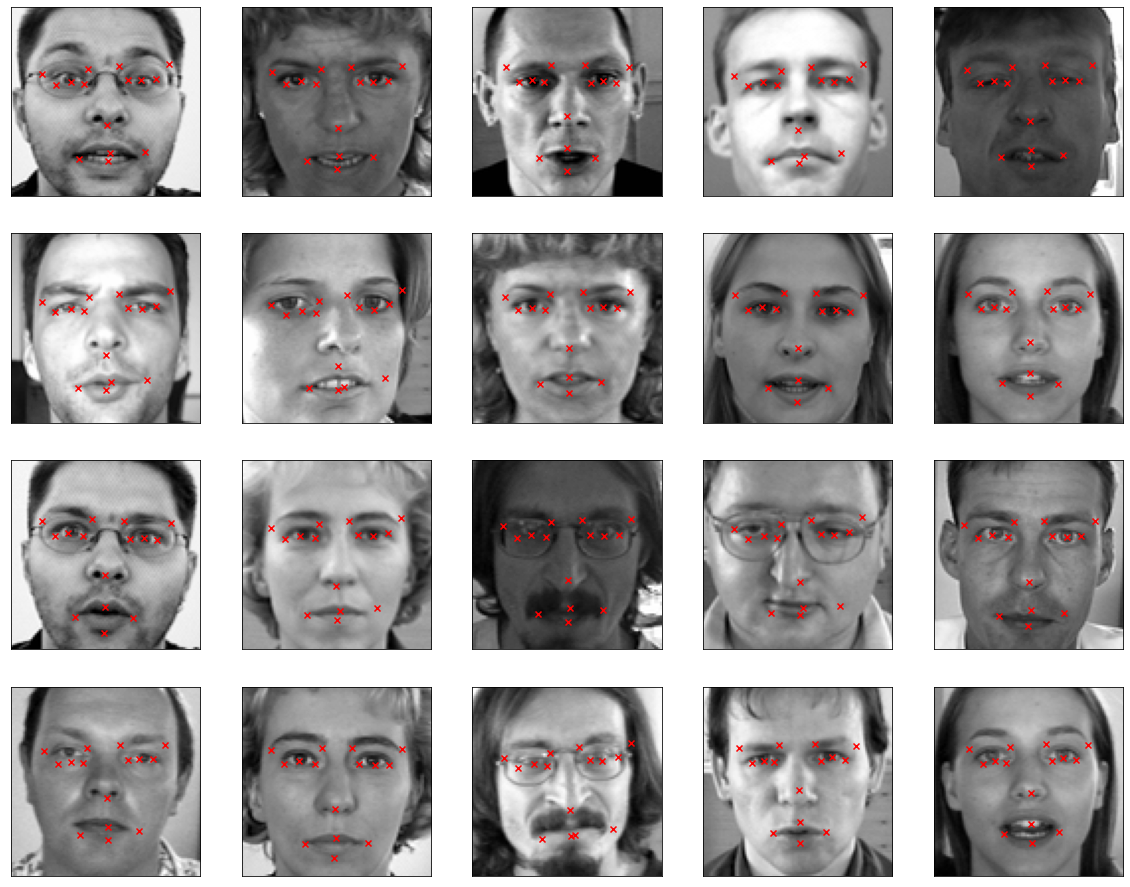

In [72]:
visually_evaluate_model(model_nn)

Shape of dataset for visually testing (1783, 96, 96, 1).
56/56 [==============================] - 0s 5ms/step


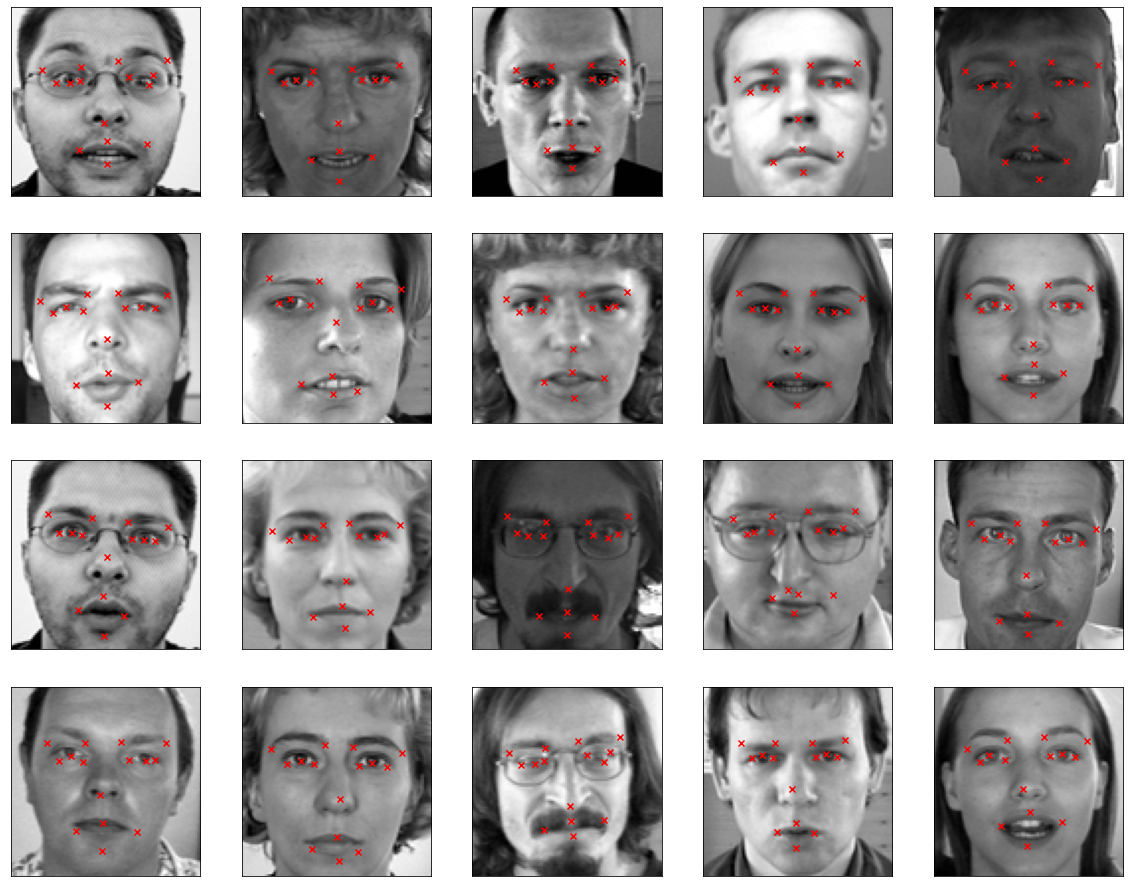

In [73]:
visually_evaluate_model(model_lenet)

Kaggle submission will be generated using LeNet-5 neural network, because it has better accuracy.

In [74]:
feature_names = list(IdLookupTable['FeatureName'])
image_ids = list(IdLookupTable['ImageId']-1)
row_ids = list(IdLookupTable['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))

In [75]:
predictions_for_submission = []
for x,y in zip(image_ids, feature_list):
    predictions_for_submission.append(predictions[x][y])

In [76]:
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions_for_submission, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

#### My Image

In [ ]:
my_image = cv2.imread("dataset/mdodovic.jpg")
print(my_image.shape)
gray_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2GRAY)

# Reshape the grayscale image
my_gray_image = gray_image.reshape(96, 96, 1)

# Check the shape of the grayscale image
print(my_gray_image.shape)

my_gray_image = np.array(my_gray_image, dtype='float')
#plt.imshow(my_gray_image, cmap='gray')
#plt.show()

(96, 96, 3)
(96, 96, 1)


In [ ]:
im = []

face_pixel = np.array(my_gray_image, dtype='float')
face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
im.append(face_pixel)

im = np.array(im)

im.shape

(1, 96, 96, 1)

In [ ]:
preds = model_for_submission.predict(im)
print(preds)


1/1 [==============================] - 0s 16ms/step
[[65.38945  37.62149  31.801401 39.153584 58.864006 36.068768 73.75514
  34.560364 37.478264 39.611706 22.402369 40.514362 53.372425 29.632307
  80.10828  27.710825 38.96317  33.426517 15.081219 36.03929  48.197765
  62.30627  71.87283  70.700554 34.20916  76.6139   51.51801  74.90693
  49.316864 73.8246  ]]


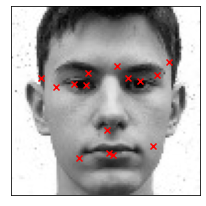

In [ ]:
fig = plt.figure(figsize=(20,16))
image = im[0].reshape(96,96)
axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
axis.imshow(image, cmap='gray')
axis.scatter(preds[0][0::2], preds[0][1::2], marker='x', c = 'red')
plt.show()